<a href="https://colab.research.google.com/github/ldsAS/Tibame-AI-Learning/blob/main/Tibame20250618_LAB_%E9%90%B5%E9%81%94%E5%B0%BC%E8%99%9F_%E8%A8%93%E7%B7%B4%E6%A8%A1%E5%BC%8F.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 鐵達尼號乘客生存 分類問題

In [1]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
class AutoPreprocess:
    def __init__(self):
        self.scaler = {}
        self.fillna_value = {}
        self.onehotencode_value = {}
        self.field_names = []
        self.final_field_names = []

    def fit(self, data, field_names):
        self.__init__()
        self.field_names = field_names

        for fname in field_names:
            #自動補空值
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
                # self.fillna_value[fname] = 'np.nan'
                # self.fillna_value[fname] = np.nan # 維持空值
            elif data[fname].dtype == bool: #布林型態
                self.fillna_value[fname] = data[fname].mode()[0] #補眾數
            else: # 數字型態
                self.fillna_value[fname] = data[fname].median()  #補中位數

            #自動尺度轉換(scaling)
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位
                pass #不用轉換
            elif data[fname].dtype == bool: #布林型態
                pass #不用轉換
            else: # 數字型態
                vc = data[fname].value_counts()
                if data[fname].isin([0, 1]).all(): #當數值只有0跟1
                    pass #不用轉換
                elif pd.api.types.is_integer_dtype(data[fname]) and data[fname].nunique() <= 10: #是否簡單的整數型類別且數量小於10
                    self.scaler[fname] = MinMaxScaler()
                    self.scaler[fname].fit(data[[fname]])
                else: #其他的數字型態
                    self.scaler[fname] = StandardScaler()
                    self.scaler[fname].fit(data[[fname]])


            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                field_value = data[fname].value_counts().index
                self.onehotencode_value[fname] = field_value
                for value in field_value:
                    fn = fname+"_"+value
                    # data[fn] = (data[fname] == value).astype('int8')
                    self.final_field_names.append(fn)
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                # data[fname] = data[fname].astype(int)
                self.final_field_names.append(fname)
            else: # 數字型態 不用重新編碼
                self.final_field_names.append(fname)

        return

    def transform(self, data):
        #如果輸入的data是dict，要先轉成dataframe
        if isinstance(data, dict):
            for fname in self.field_names:
                if fname in data:
                    data[fname] = [data[fname]]
                else:
                    data[fname] = [np.nan]
            data = pd.DataFrame(data)
        else: #將資料複製一份，不修改原本的資料
            data = data.copy()

        for fname in self.field_names:
            #自動補空值
            if data[fname].isnull().any(): #有空值
                # if fname in self.fillna_value:
                    data[fname] = data[fname].fillna(self.fillna_value[fname])


            #自動尺度轉換(scaling)
            if fname in self.scaler:
                data[fname] = self.scaler[fname].transform(data[[fname]])

            #自動編碼
            if (data[fname].dtype == object) or (data[fname].dtype == str): #字串型態欄位, onehotencode
                if fname in self.onehotencode_value:
                    field_value = self.onehotencode_value[fname]
                for value in field_value:
                    fn = fname+"_"+value
                    data[fn] = (data[fname] == value).astype('int8')
            elif data[fname].dtype == bool: #布林型態 轉成0跟1
                data[fname] = data[fname].astype(int)
            else: # 數字型態 不用重新編碼
                pass
        return data[self.final_field_names]

    def save(self, file_name):
        with open(file_name, "wb") as f:
            pickle.dump(self, f)

    @staticmethod
    def load(file_name):
        with open(file_name, "rb") as f:
            return pickle.load(f)

In [2]:
#載入訓練用資料
import pandas as pd
import numpy as np
data = pd.read_csv('../content/Titanic(鐵達尼號乘客)_Train.csv')
data.head()

,乘客序號,船票等級,姓名,性別,年紀,旁系親屬數目,直系親屬數目,船票編號,船票價格,船艙號碼,出發港口,是否倖存
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


In [3]:
data.columns

Index(['乘客序號', '船票等級', '姓名', '性別', '年紀', '旁系親屬數目', '直系親屬數目', '船票編號', '船票價格',
       '船艙號碼', '出發港口', '是否倖存'],
      dtype='object')

In [6]:
data.shape

(891, 12)

In [8]:
ap = AutoPreprocess()
ap.fit(data, ['船票等級', '性別', '年紀', '旁系親屬數目', '直系親屬數目', '船票價格', '出發港口'])
ap.save("preprocess.bin")

X = ap.transform(data)
y = data['是否倖存']

In [9]:
X.columns

Index(['船票等級', '性別_male', '性別_female', '年紀', '旁系親屬數目', '直系親屬數目', '船票價格',
       '出發港口_S', '出發港口_C', '出發港口_Q'],
      dtype='object')

# 方法一

In [10]:
from sklearn.model_selection import train_test_split
# 分割資料成訓練組跟驗證組
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=0)

In [12]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

## 下面幾個模型選一個
# model = RandomForestClassifier(n_estimators=50)
model = MLPClassifier(hidden_layer_sizes=(100,))
# model = AdaBoostClassifier(n_estimators=50)
# model = GradientBoostingClassifier(n_estimators=50)
# model = KNeighborsClassifier(n_neighbors=5)

model.fit(X_train, y_train)

#儲存模型
import pickle
with open("model.bin", "wb") as f:
    pickle.dump(model, f)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


# 驗證模型

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score

y_pred = model.predict(X_train)
f1 = f1_score(y_train, y_pred)
print("訓練組 f1:", f1)
precision = precision_score(y_train, y_pred)
print("訓練組 precision:", precision)
recall = recall_score(y_train, y_pred)
print("訓練組 recall:", recall)

y_pred = model.predict_proba(X_train)[:,1]
roc_auc = roc_auc_score(y_train, y_pred)
print("訓練組 roc_auc:", roc_auc)

y_pred2 = model.predict(X_valid)
f1 = f1_score(y_valid, y_pred2)
print("驗證組 f1:", f1)
precision = precision_score(y_valid, y_pred2)
print("驗證組 precision:", precision)
recall = recall_score(y_valid, y_pred2)
print("驗證組 recall:", recall)

y_pred2 = model.predict_proba(X_valid)[:,1]
roc_auc = roc_auc_score(y_valid, y_pred2)
print("驗證組 roc_auc:", roc_auc)

訓練組 f1: 0.7770700636942676
訓練組 precision: 0.8591549295774648
訓練組 recall: 0.7093023255813954
訓練組 roc_auc: 0.8842030629608622
驗證組 f1: 0.7564102564102564
驗證組 precision: 0.8194444444444444
驗證組 recall: 0.7023809523809523
驗證組 roc_auc: 0.8841640972935936


驗證組 roc_auc: 0.8841640972935936
驗證組 precision: 0.8194444444444444
驗證組 recall: 0.7023809523809523


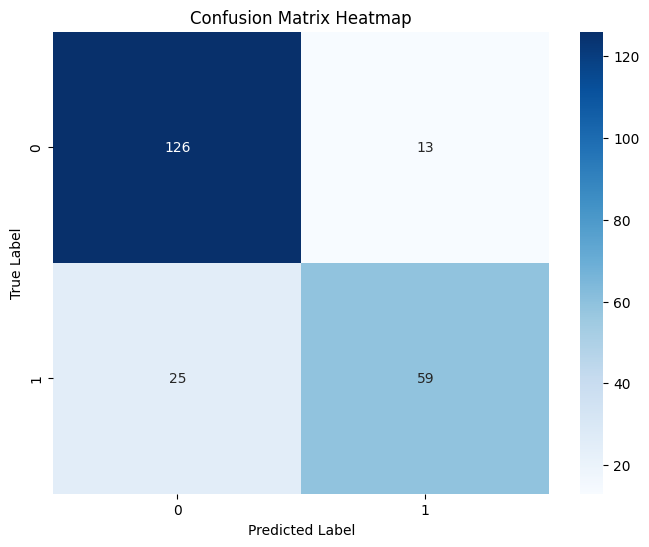

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

threshold = 0.5 #這裡可以調整

# 預測結果
y_pred_proba = model.predict_proba(X_valid)[:,1]
y_pred = (y_pred_proba >= threshold).astype('int')

roc_auc = roc_auc_score(y_valid, y_pred_proba)
print("驗證組 roc_auc:", roc_auc)
precision = precision_score(y_valid, y_pred)
print("驗證組 precision:", precision)
recall = recall_score(y_valid, y_pred)
print("驗證組 recall:", recall)

# 計算混淆矩陣
cm = confusion_matrix(y_valid, y_pred)

# 繪製 heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
